In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt
import re

In [2]:
csv_path = "properties.csv"

df = pd.read_csv(csv_path, header=None, encoding="utf-8", na_values=["NA", "NaN", "", "Missing value", "missing value"])

df.columns = [
    "reference",
    "location",
    "price",
    "title",
    "bedrooms",
    "bathrooms",
    "indoor_sqm",
    "outdoor_sqm",
    "features"
]

df.count()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'properties.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12086 entries, 0 to 12085
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reference    12086 non-null  object 
 1   location     12086 non-null  object 
 2   price        12086 non-null  object 
 3   title        12086 non-null  object 
 4   bedrooms     12084 non-null  float64
 5   bathrooms    10952 non-null  float64
 6   indoor_sqm   10414 non-null  float64
 7   outdoor_sqm  3821 non-null   float64
 8   features     11505 non-null  object 
dtypes: float64(4), object(5)
memory usage: 849.9+ KB


In [ ]:
df["price"].head(10)
def clean_price_to_eur(s):

    if pd.isna(s):
        return np.nan
    
    s = str(s)
    
    s = s.replace("â‚¬", "€")

    digits = "".join(ch for ch in s if ch.isdigit())
    
    if digits == "":
        return np.nan
    
    return float(digits)

df["price_eur"] = df["price"].apply(clean_price_to_eur)

df = df.dropna(subset=["price_eur"])

df[["price", "price_eur"]].head()

,price,price_eur
0,"€450,000",450000.0
1,"€1,250,000",1250000.0
2,"€749,000",749000.0
3,"€500,000",500000.0
4,"€1,695,000",1695000.0


In [ ]:
for col in ["bedrooms", "bathrooms", "indoor_sqm", "outdoor_sqm"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_cols = ["bedrooms", "bathrooms", "indoor_sqm", "outdoor_sqm"]
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

df[numeric_cols].describe()

,bedrooms,bathrooms,indoor_sqm,outdoor_sqm
count,1.208600e+04,1.208600e+04,12086.000000,1.208600e+04
mean,2.533099e+03,9.756688e+02,221.178305,4.209443e+03
std,9.852328e+04,4.413704e+04,247.957352,1.103327e+05
min,0.000000e+00,0.000000e+00,10.000000,1.000000e+00
25%,2.000000e+00,2.000000e+00,107.000000,1.009000e+03
50%,3.000000e+00,2.000000e+00,144.500000,1.009000e+03
75%,5.000000e+00,3.500000e+00,234.000000,1.009000e+03
max,9.700000e+06,4.630000e+06,5367.000000,9.350000e+06


In [ ]:
def extract_property_type(title):
    if pd.isna(title):
        return np.nan

    t = str(title).strip()

    t = re.sub(r"\s+", " ", t)

    m = re.match(r"^\d+\s+Bedrooms?\s+(.*)$", t, flags=re.IGNORECASE)
    if m:
        prop_type = m.group(1).strip()
        return prop_type if prop_type else t

    m = re.match(r"^\d+\s+(.*)$", t)
    if m:
        prop_type = m.group(1).strip()
        return prop_type if prop_type else t

    return t

df["property_type"] = df["title"].apply(extract_property_type)
df[["title", "property_type"]].head(20)

,title,property_type
0,3 Bedroom Apartment,Apartment
1,Other,Other
2,12 Bedroom Finca,Finca
3,Plot,Plot
4,4 Bedroom Detached Villa,Detached Villa
5,4 Bedroom Semi-detached,Semi-detached
6,3 Bedroom Penthouse,Penthouse
7,5 Bedroom Detached Villa,Detached Villa
8,3 Bedroom Town House,Town House
9,2 Bedroom Apartment,Apartment


In [ ]:
corr = ["price_eur"] + numeric_cols

df[corr].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
price_eur,12086.0,1.046977e+06,1.881298e+06,4500.0,70000.0,154000.00,475000.0,3850000.0,8500000.00,50000000.0
bedrooms,12086.0,2.533099e+03,9.852328e+04,0.0,0.0,1.00,3.0,885.0,10030.15,9700000.0
bathrooms,12086.0,9.756688e+02,4.413704e+04,0.0,1.0,1.00,2.0,10.0,5012.45,4630000.0
indoor_sqm,12086.0,2.211783e+02,2.479574e+02,10.0,47.0,68.00,144.5,627.0,1160.00,5367.0
outdoor_sqm,12086.0,4.209443e+03,1.103327e+05,1.0,28.0,143.25,1009.0,4000.0,28067.05,9350000.0


In [ ]:
corr_pearson = df[corr].corr(method="pearson")
corr_spearman = df[corr].corr(method="spearman")

print("Pearson correlations:")
display(corr_pearson)

print("\nSpearman correlations:")
display(corr_spearman)

Pearson correlations:


,price_eur,bedrooms,bathrooms,indoor_sqm,outdoor_sqm
price_eur,1.000000,0.087268,0.170317,0.636846,0.129895
bedrooms,0.087268,1.000000,0.000321,-0.007928,-0.000744
bathrooms,0.170317,0.000321,1.000000,-0.006787,-0.000637
indoor_sqm,0.636846,-0.007928,-0.006787,1.000000,0.106021
outdoor_sqm,0.129895,-0.000744,-0.000637,0.106021,1.000000



Spearman correlations:


,price_eur,bedrooms,bathrooms,indoor_sqm,outdoor_sqm
price_eur,1.000000,0.465411,0.632161,0.693415,0.165196
bedrooms,0.465411,1.000000,0.499252,0.639346,0.143047
bathrooms,0.632161,0.499252,1.000000,0.738552,0.129606
indoor_sqm,0.693415,0.639346,0.738552,1.000000,0.184230
outdoor_sqm,0.165196,0.143047,0.129606,0.184230,1.000000


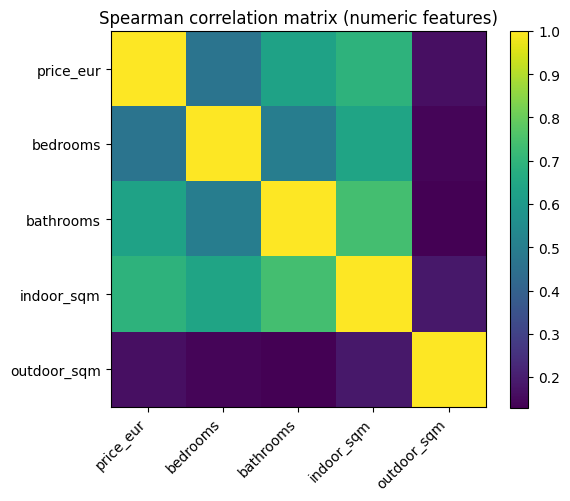

In [ ]:
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_spearman, cmap="viridis")
plt.colorbar(im)
plt.xticks(range(len(corr)), corr, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr)
plt.title("Spearman correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

In [ ]:
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

for col in corr:
    low, high = iqr_bounds(df[col])
    outlier_mask = (df[col] < low) | (df[col] > high)
    n_out = outlier_mask.sum()
    print(f"{col}: {n_out} potential outliers (bounds: {low:.2f} and {high:.2f})")

price_eur: 1375 potential outliers (bounds: -780000.00 and 2060000.00)
bedrooms: 1557 potential outliers (bounds: -2.50 and 9.50)
bathrooms: 1224 potential outliers (bounds: -0.25 and 5.75)
indoor_sqm: 1354 potential outliers (bounds: -83.50 and 424.50)
outdoor_sqm: 3819 potential outliers (bounds: 1009.00 and 1009.00)


In [ ]:
df_clean = df.copy()

df_clean = df_clean[df_clean["price_eur"] > 0]
df_clean = df_clean[(df_clean["bedrooms"] >= 0) & (df_clean["bedrooms"] <= 20)]
df_clean = df_clean[(df_clean["bathrooms"] >= 0) & (df_clean["bathrooms"] <= 20)]
df_clean = df_clean[(df_clean["indoor_sqm"] > 0) & (df_clean["indoor_sqm"] <= 2000)]
df_clean = df_clean[(df_clean["outdoor_sqm"] > 0) & (df_clean["outdoor_sqm"] <= 100000)]

print("Original shape:", df.shape)
print("After sanity filters:", df_clean.shape)

Original shape: (12086, 11)
After sanity filters: (10387, 11)


In [ ]:
cols_to_cap = ["price_eur", "indoor_sqm", "outdoor_sqm"]

caps = {}
for col in cols_to_cap:
    low_q = df_clean[col].quantile(0.01)
    high_q = df_clean[col].quantile(0.99)
    caps[col] = (low_q, high_q)
    print(f"{col}: 1%={low_q:.2f}, 99%={high_q:.2f}")

for col, (low_q, high_q) in caps.items():
    df_clean[col] = df_clean[col].clip(lower=low_q, upper=high_q)

df_clean[cols_to_cap].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T

price_eur: 1%=99000.00, 99%=7814000.00
indoor_sqm: 1%=46.00, 99%=1100.00
outdoor_sqm: 1%=25.00, 99%=23049.00


,count,mean,std,min,1%,5%,50%,95%,99%,max
price_eur,10387.0,965438.034755,1.299119e+06,99000.0,99000.0,174620.0,480000.0,3687000.0,7801960.00,7814000.0
indoor_sqm,10387.0,220.720323,1.968000e+02,46.0,46.0,65.0,144.0,645.0,1100.00,1100.0
outdoor_sqm,10387.0,1558.589968,2.845461e+03,25.0,25.0,106.0,1009.0,4305.6,23006.86,23049.0


In [ ]:
def merge_rare_categories(df, col, min_freq=0.01):
    df = df.copy()
    freq = df[col].value_counts(normalize=True)
    rare = freq[freq < min_freq].index
    other_label = f"Other_{col}"
    df[col] = df[col].where(~df[col].isin(rare), other_label)
    return df

In [ ]:
df_clean = merge_rare_categories(df_clean, "location", min_freq=0.01)
df_clean = merge_rare_categories(df_clean, "property_type", min_freq=0.01)

print(df_clean["location"].nunique(), "locations after merge")
print(df_clean["property_type"].nunique(), "property types after merge")

28 locations after merge
9 property types after merge


In [ ]:
cat_cols = ["location", "property_type"]

df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

df_encoded.head()

,reference,price,title,bedrooms,bathrooms,indoor_sqm,outdoor_sqm,features,price_eur,"location_Alhaurín el Grande, Costa del Sol",...,"location_San Pedro de Alcántara, Costa del Sol","location_The Golden Mile, Costa del Sol",property_type_Detached,property_type_Detached Villa,property_type_Finca,property_type_Ground Flat,property_type_Other_property_type,property_type_Penthouse,property_type_Semi-detached,property_type_Town House
0,R126116,"€450,000",3 Bedroom Apartment,3.0,2.0,120.0,1009.0,Close to Shops|Electricity Utilities|Close to ...,450000.0,False,...,False,False,False,False,False,False,False,False,False,False
2,R121563,"€749,000",12 Bedroom Finca,12.0,7.0,366.0,5353.0,Mountain Views|Private Garden|Open Parking|Urb...,749000.0,False,...,False,False,False,False,True,False,False,False,False,False
4,R114041,"€1,695,000",4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,Private Garden|Electricity Utilities|Drinkable...,1695000.0,False,...,False,False,False,True,False,False,False,False,False,False
5,R134059,"€480,000",4 Bedroom Semi-detached,4.0,2.0,130.0,350.0,Close to Shops|Private Garden|Electricity Util...,480000.0,False,...,False,False,False,False,False,False,False,False,True,False
6,R111747,"€850,000",3 Bedroom Penthouse,3.0,2.0,281.0,1009.0,Urban Views|Electricity Utilities|Drinkable Wa...,850000.0,False,...,True,False,False,False,False,False,False,True,False,False


In [ ]:
df_encoded["features_list"] = (
    df_clean["features"]
    .fillna("")
    .apply(lambda x: [f.strip() for f in str(x).split("|") if f.strip() != ""])
)

df_encoded["features_list"].head()

0    [Close to Shops, Electricity Utilities, Close ...
2    [Mountain Views, Private Garden, Open Parking,...
4    [Private Garden, Electricity Utilities, Drinka...
5    [Close to Shops, Private Garden, Electricity U...
6    [Urban Views, Electricity Utilities, Drinkable...
Name: features_list, dtype: object

In [ ]:
mlb = MultiLabelBinarizer()

features_matrix = mlb.fit_transform(df_encoded["features_list"])
feature_names = [f"feat_{f}" for f in mlb.classes_]

features_df = pd.DataFrame(
    features_matrix,
    columns=feature_names,
    index=df_encoded.index
)

df_model = pd.concat(
    [df_encoded.drop(columns=["features", "features_list"]) , features_df],
    axis=1
)

df_model.head()

,reference,price,title,bedrooms,bathrooms,indoor_sqm,outdoor_sqm,price_eur,"location_Alhaurín el Grande, Costa del Sol","location_Benahavís, Costa del Sol",...,feat_U/F Heating Climate Control,feat_Underground Parking,feat_Urban Views,feat_Urbanisation,feat_Utility Room,feat_Village,feat_West Orientation,feat_WiFi,feat_With Planning Permission,feat_Wood Flooring
0,R126116,"€450,000",3 Bedroom Apartment,3.0,2.0,120.0,1009.0,450000.0,False,False,...,0,0,0,1,0,0,0,0,0,0
2,R121563,"€749,000",12 Bedroom Finca,12.0,7.0,366.0,5353.0,749000.0,False,False,...,0,0,1,0,0,0,0,0,0,0
4,R114041,"€1,695,000",4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,1695000.0,False,False,...,0,0,0,0,0,0,0,0,0,0
5,R134059,"€480,000",4 Bedroom Semi-detached,4.0,2.0,130.0,350.0,480000.0,False,False,...,0,0,0,0,0,0,0,0,0,0
6,R111747,"€850,000",3 Bedroom Penthouse,3.0,2.0,281.0,1009.0,850000.0,False,False,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
y = df_model["price_eur"]

X = df_model.drop(
    columns=[
        "price_eur",
        "price",
        "reference",
        "title"
    ],
    errors="ignore"
)

X.shape, y.shape

((10387, 186), (10387,))